In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from pathlib import Path

In [1]:
# SET MAIN HYPERPARAMETERS
TRAIT_LABEL = "Open-minded"
TRAIT_LABEL_SAVE_STRING = TRAIT_LABEL.replace(" ", "_").replace("-", "_")
STIMULUS_LABEL = "1Pieman"         # How stimulus is labeled in the trait data
STIMULUS_LABEL_SAVE_STRING = "pieman"  # How stimulus is labeled in the output  
TRAIT_LABEL_SAVE_STRING




'Open_minded'

In [3]:
# ----------------------------------------------------------------------
# 0) TRAIT-SPECIFIC SMOOTHING WINDOWS  (edit here when you add traits)
# ----------------------------------------------------------------------
WIN_DICT: dict[str, int] = {
    "Open-minded"      : 200,
    "feeling Affectionate"     : 200,
    "Attentive"        : 200,
    "Assertive"        : 200,
    "feeling Gloomy"           : 200,
    "feeling Peaceful"         : 175,
    "Agreeable"        : 200,
    "Judging"          : 150,
    "feeling Angry"            : 0,
    "feeling Bewildered"       : 50,
    "Impulsive"        : 25,
    "Self-disciplined" : 0,
    "Contemplating"    : 0,    
}


In [4]:
# --------------------------------------------------------------------------
# MAIN FUNCTION
# --------------------------------------------------------------------------
def build_behavior_template(
        csv_path   : str | Path,
        stim_label : str = STIMULUS_LABEL,
        trait_label: str = TRAIT_LABEL,
        win_dict   : dict[str, int] = WIN_DICT,
        tr_sec     : float = 1.5,
        n_tr       : int = 160,
        sd_cutoff  : float = 5.0,
        max_sec    : float = 240.0,      # ignore anything after this - this grabs 0-239
) -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Returns
    -------
    vec : (160,) np.ndarray
        Down‑sampled + smoothed group‑average time series.
    RDM : (160,160) np.ndarray
        1‑D absolute‑difference dissimilarity matrix derived from `vec`.
            df  : pd.DataFrame
        Cleaned and smoothed ratings table (for debugging).
    """

    # Sanity check: window must exist
    if trait_label not in win_dict:
        raise KeyError(f"No smoothing window for '{trait_label}' – add it to WIN_DICT.")

    # 0) ----------------------------------------------------------------------
    # load CSV and keep rows for this stim × trait, within first 240 s
    # ------------------------------------------------------------------------
    df = pd.read_csv(csv_path)
    df = df[(df["stim"] == stim_label)
            & (df["task"] == trait_label)
            & (df["time"]  < max_sec)].copy()

    # 1) ----------------------------------------------------------------------
    # exclude raters whose SD < sd_cutoff
    # ------------------------------------------------------------------------
    sd = df.groupby("subject")["rating"].std()
    bad_sd = sd[sd < sd_cutoff].index
    df  = df[~df["subject"].isin(bad_sd)]
    print(f"Excluded {len(bad_sd)} raters (SD < {sd_cutoff}). Kept {df['subject'].nunique()}.")

    # 2) ----------------------------------------------------------------------
    # map each rating sample into a TR bin (0‥159)
    # ------------------------------------------------------------------------
    df["TR"] = (df["time"] / tr_sec).round().astype(int)
    df = df[(df["TR"] >= 0) & (df["TR"] < n_tr)]

    # 3) ----------------------------------------------------------------------
    # smooth each rater's series with a sliding‑mean window
    # ------------------------------------------------------------------------
    window = win_dict[trait_label]
    if window < 1:
        print(f"[{trait_label}] smoothing window = {window} → no smoothing applied")
        df["rating_sm"] = df["rating"]
    else:
        print(f"[{trait_label}] smoothing window = {window} samples")
        def _smooth(s):
            return s.rolling(window, center=True, min_periods=1).mean()
        df["rating_sm"] = (
            df.groupby("subject")["rating"]
              .apply(_smooth)
              .reset_index(level=0, drop=True)
        )


    # 4) ----------------------------------------------------------------------
    # average within each TR across raters  → (160,) vector
    # ------------------------------------------------------------------------
    pivot = (df.pivot_table(index="TR", columns="subject",
                            values="rating_sm", aggfunc="mean")
               .reindex(range(n_tr))
               .interpolate(limit_direction="both"))
    vec = pivot.mean(axis=1).values          # shape (160,)

    # 5) ----------------------------------------------------------------------
    # build 160×160 absolute‑difference dissimilarity matrix
    # ------------------------------------------------------------------------
    RDM = squareform(pdist(vec[:, None], metric="cityblock"))  # Manhattan distance: |xi‑xj|

    # ------------------------------------------------------------------
    # 6) sanity-check: report the window that was actually used
    # ------------------------------------------------------------------
    return vec, RDM, df

    


# --------------------------------------------------------------------------
# EXAMPLE: build the template and save the RDM
# --------------------------------------------------------------------------
csv_file = "/Volumes/Passport/fmriprep/trait_ratings_data/chujun_data.csv"
vec, RDM, df = build_behavior_template(
    csv_path   = csv_file,
    stim_label = STIMULUS_LABEL,
    trait_label= TRAIT_LABEL,
)

# save for RSA
out_dir = Path("/Volumes/Passport/fmriprep/derivatives/RDMs_behavior")
out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / f"{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_vec.npy", vec)   
np.save(out_dir / f"{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_RDM.npy", RDM)
print("Saved vector  →", out_dir / f"{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_vec.npy")
print("Saved:", out_dir / f"{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_RDM.npy")

Excluded 2 raters (SD < 5.0). Kept 21.
[Open-minded] smoothing window = 200 samples
Saved vector  → /Volumes/Passport/fmriprep/derivatives/RDMs_behavior/pieman_Open_minded_vec.npy
Saved: /Volumes/Passport/fmriprep/derivatives/RDMs_behavior/pieman_Open_minded_RDM.npy


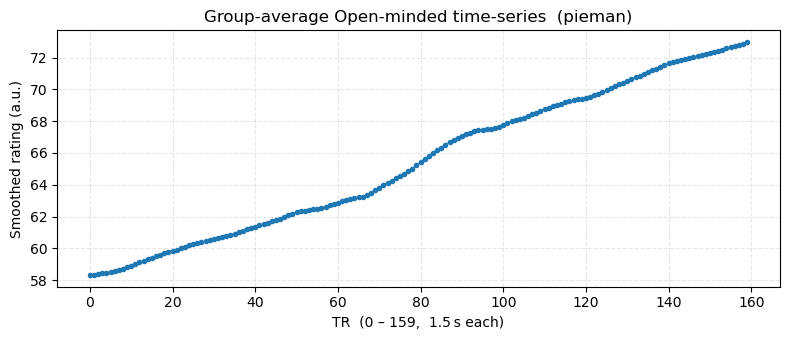

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1)  Load the vector you saved earlier
#     (skip this line if `vec_aff` is already in memory)
# ------------------------------------------------------------------
vec_path = f"/Volumes/Passport/fmriprep/derivatives/RDMs_behavior/{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_vec.npy"
vec      = np.load(vec_path)        # shape = (160,)

# ------------------------------------------------------------------
# 2)  Plot the 160‑point time‑series
# ------------------------------------------------------------------
plt.figure(figsize=(8, 3.5))
plt.plot(np.arange(160), vec, marker="o", ms=3, lw=1)
plt.title(f"Group‑average {TRAIT_LABEL} time‑series  ({STIMULUS_LABEL_SAVE_STRING})")
plt.xlabel("TR  (0 – 159,  1.5 s each)")
plt.ylabel("Smoothed rating (a.u.)")
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()

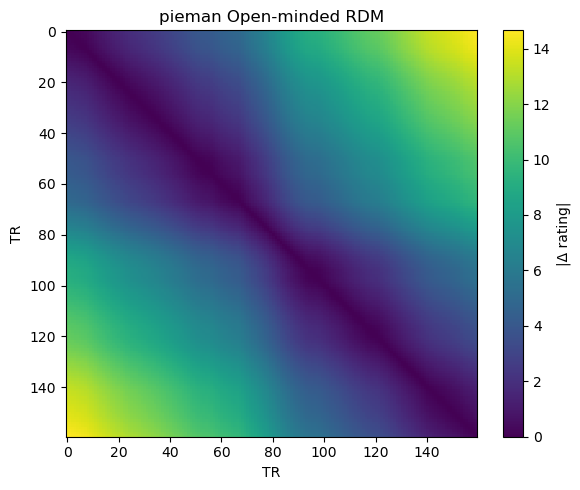

In [6]:
import numpy as np
import matplotlib.pyplot as plt

RDM = np.load(f"/Volumes/Passport/fmriprep/derivatives/RDMs_behavior/{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_RDM.npy")  # (160,160)

plt.figure(figsize=(6,5))
plt.imshow(RDM, interpolation="nearest", aspect="auto")
plt.title(f"{STIMULUS_LABEL_SAVE_STRING} {TRAIT_LABEL} RDM")
plt.xlabel("TR");  plt.ylabel("TR")
cbar = plt.colorbar();  cbar.set_label("|Δ rating|")
plt.tight_layout();  plt.show()

In [26]:
import numpy as np

# load your vector and RDM
vec = np.load(f"/Volumes/Passport/fmriprep/derivatives/RDMs_behavior/{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_vec.npy")          # (160,)
RDM = np.load(f"/Volumes/Passport/fmriprep/derivatives/RDMs_behavior/{STIMULUS_LABEL_SAVE_STRING}_{TRAIT_LABEL_SAVE_STRING}_RDM.npy")  # (160,160)

# 1) correct lengths
assert vec.shape == (160,),  "Vector should be length 160"
assert RDM.shape == (160,160), "RDM should be 160×160"

# 2) RDM symmetry and zero diagonal
assert np.allclose(RDM, RDM.T), "RDM not symmetrical"
assert np.allclose(np.diag(RDM), 0), "Diagonal should be zeros"

# 3) RDM recomputes exactly from vec
from scipy.spatial.distance import pdist, squareform
assert np.allclose(RDM, squareform(pdist(vec[:,None], 'cityblock'))), \
       "RDM does not match |Δ| of vector"
print("All sanity‑checks passed ✔️")

All sanity‑checks passed ✔️
